**HOW HOT CAN e-MOTORS MOTORS GET?**

I aim to provide answers to the questions below, with the help of 180 hours of data collected from a permanent magnet synchronous motor (PMSM) by the LEA department at Paderborn University. 


1.   What are the different types of driving profiles?
2.   Which part of the e-motor reaches the highest temperature?
3.   What factors correlate well to the temperature build-up?
4.   How well we can predict the temperature of critical components with a simple linear regression model?

**Using Colab & Google Drive**

In [2]:
# using Google Drive in Colab   
from google.colab import drive
drive.mount('/drive/')

Mounted at /drive/


**Imports**

In [3]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import rgb2hex
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

**EXPLORING THE DATA**

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University.

In [4]:
# loading the data
# checking data types, column names, and row counts
df = pd.read_csv('/drive/MyDrive/measures_v2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB



As we can see above, we have 12 variable in our data which are all numeric variables with non-null values. That means that we do not need to handle null values, as well as non-numeric columns.


In [5]:
df.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


**Motor Driving Cycles**

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

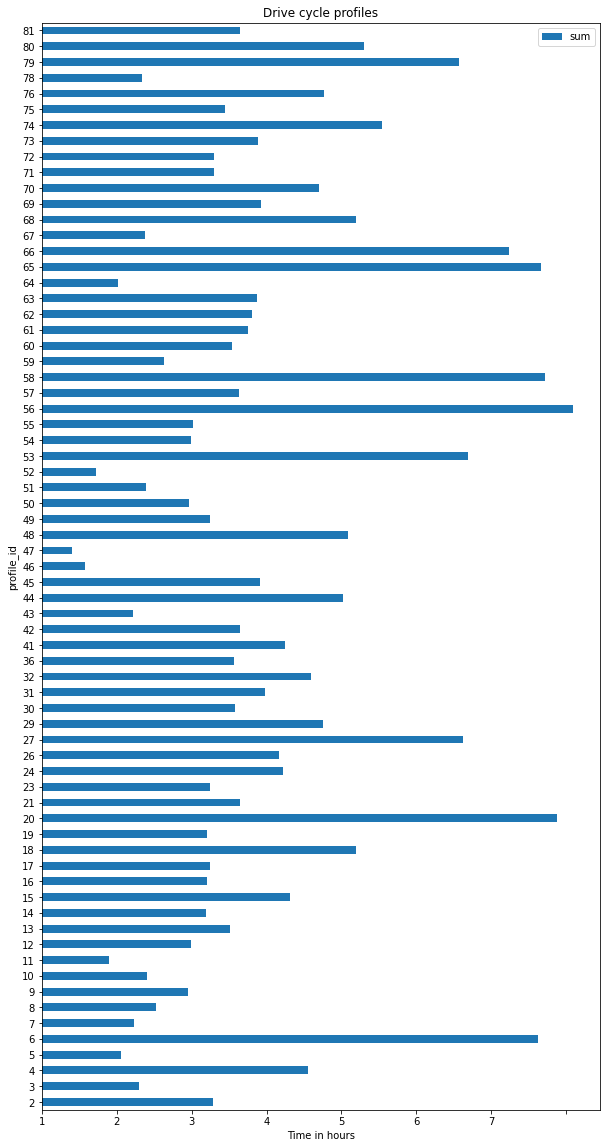

In [6]:
# converting 2hz measurements to see the test duration in hour
profiles_df = df.groupby('profile_id')['stator_winding'].agg(['sum']).apply(lambda x: x/(2*3600*60))

# ploting the drive profiles in hour
ax = profiles_df.plot.barh(figsize=(10, 20), title='Drive cycle profiles', )
_ = ax.set_xticklabels(list(range(1, 8)))
_ = ax.set_xlabel('Time in hours')

**Correlation Matrix**

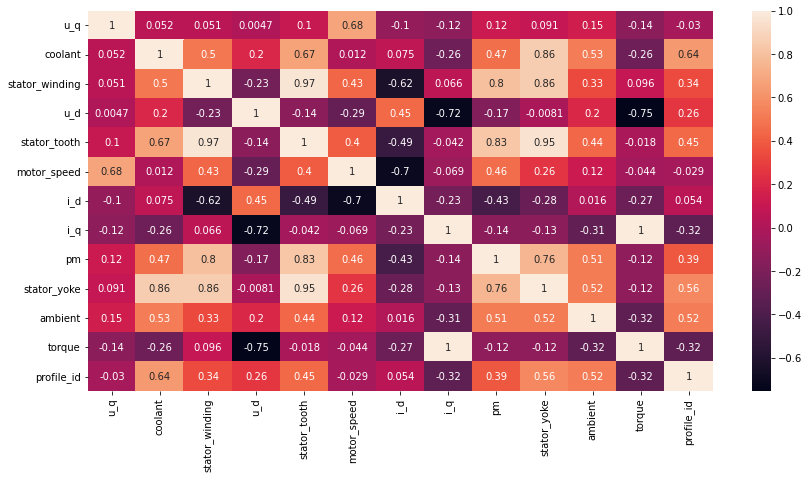

In [7]:
plt.figure(figsize=(14,7))
sns.heatmap(df.corr(),annot=True)

**Histogram Plots of Variables**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


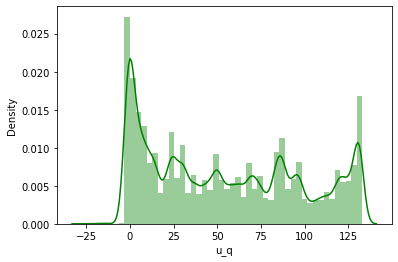

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


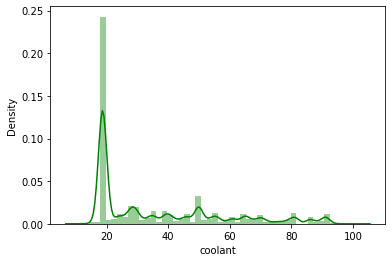

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


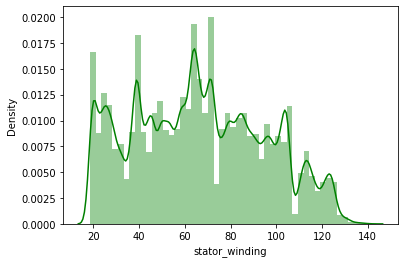

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


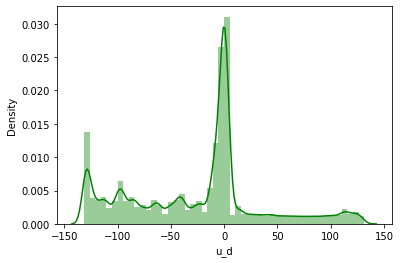

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


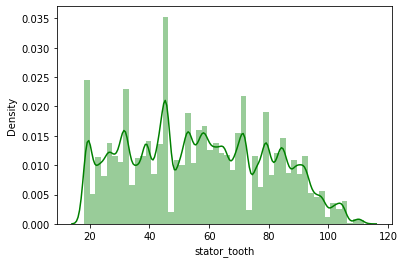

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


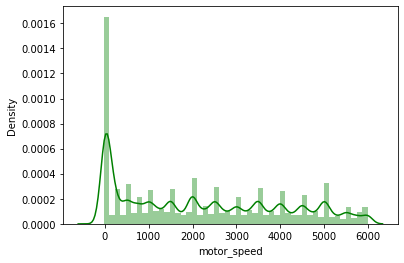

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


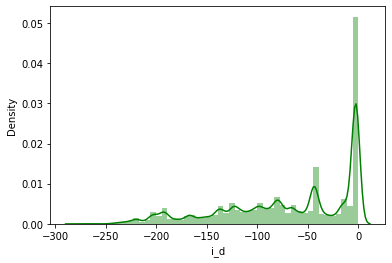

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


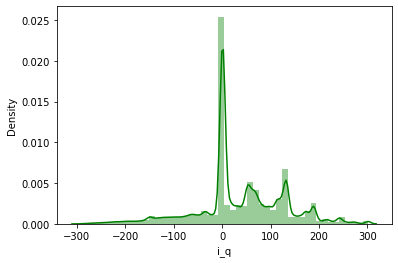

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


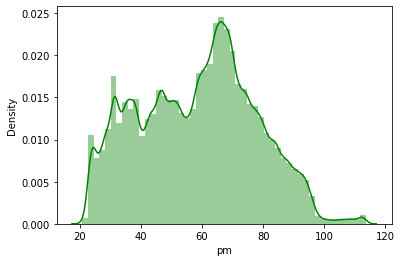

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


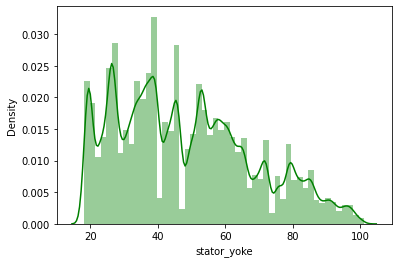

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


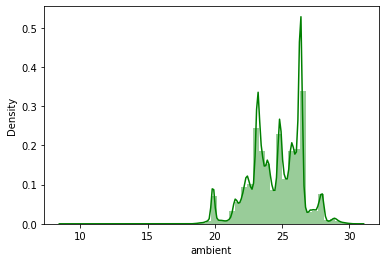

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


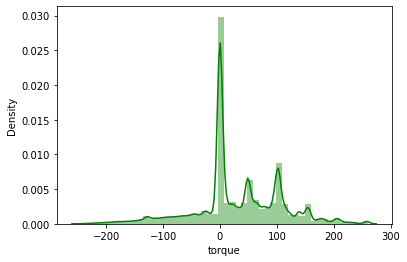

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


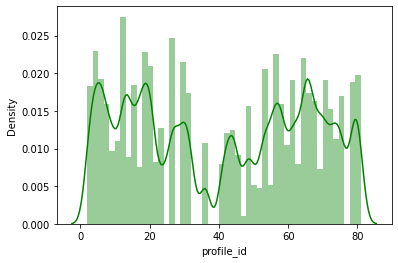

In [ ]:
for i in df.columns:
    sns.distplot(df[i],color='g')
    plt.show()

**PART I: WHAT ARE THE DIFFERENT TYPES OF DRIVING PROFILES (e-MOTOR SPEED CHARACTERISTICS)?**

There are 81 different drive profiles in the dataset with each having unique engine speed characteristics. Still, we can group the profiles considering variation-based similarities in engine speed during the test sessions, as listed below.

In [13]:
def plot_profiles(profiles, target_features,n_cols,y_label,density_plot=False,corr_plot=False,sample_plot=True):
    """Generates graph using the profiles and the target features.
    
    Args:
        profiles (list): List of integers representing the profile numbers
        target_features (list): List of variables as string representing variables you want on the graph
        n_cols (int): Defines how many columns will be generated
        y_label (string): Y axis label for the graph
        density_plot (boolean): When false density graph is not shown
        corr_plot (boolean): When false correlation graph is not shown
        sample_plot (boolean): When false main graph is not shown
    
    Returns: 
        None
    """
    grpd = {pid: df  for pid ,  df in df.groupby('profile_id') if pid in profiles}
    df_grp = pd.concat(grpd.values(), ignore_index=True)

    if density_plot:
        for i in range(len(target_features)):
          sns.distplot(df_grp[target_features[i]])

    if corr_plot:
        plt.figure(figsize=(14,7))
        sns.heatmap(df_grp.corr(),annot=True)
    
    if  sample_plot:
        dfui = df.drop(['profile_id'], axis=1)

        # prepare colors
        color_list = plt.cm.tab10(np.linspace(0, 1, 10)[list(range(10))+[0, 1]])
        coi = target_features + [c for c in dfui if c not in target_features]  # columns of interest
        feat_clrs = {k: rgb2hex(color_list[i][:3]) for i, k in enumerate(coi)} if color_list is not None else {}

        coi = target_features
        n_rows = np.ceil(len(grpd) / n_cols).astype(int)

        fig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(5*n_cols, n_rows*5))
        for i, (ax, (p_id, df_)) in enumerate(zip(axes.flatten(), grpd.items())):
            for c in coi:
               lines = ax.plot(df_[c].reset_index(drop=True), label=c, color=feat_clrs[c])
            ax.set_title(f'profile {p_id}')
            if i % n_cols == 0:
                ax.set_ylabel(y_label)
            if i >= (len(grpd) - n_cols):
                ax.set_xlabel('Sample')
        fig.tight_layout()
        _ = ax.legend(ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

**Constant Speed Profiles**

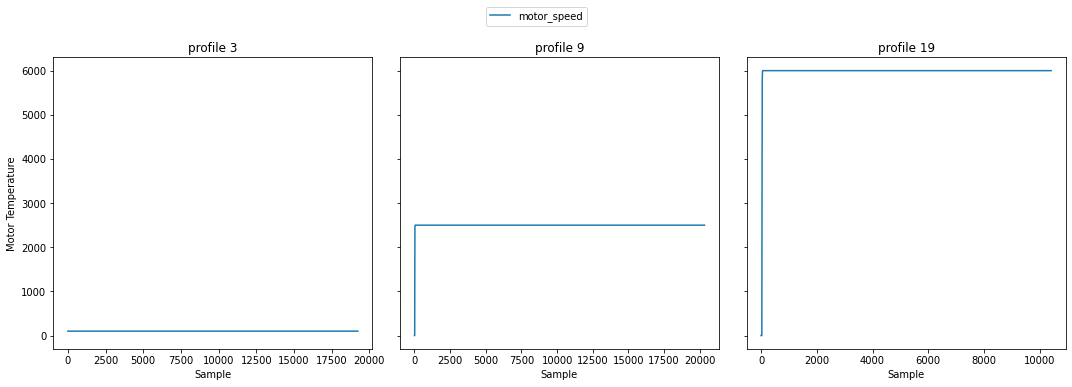

In [ ]:
constant_speed_profiles = [3,5,7,8,9,12,13,14,15,16,17,18,19,21,23,24,26]
constant_speed_profile_examples = [3,9,19]
target_features = ['motor_speed']
n_columns = 3
y_label = 'Motor Temperature in °C'

plot_profiles(constant_speed_profile_examples,target_features,n_columns,y_label)

**Stepwise Speed Profiles**

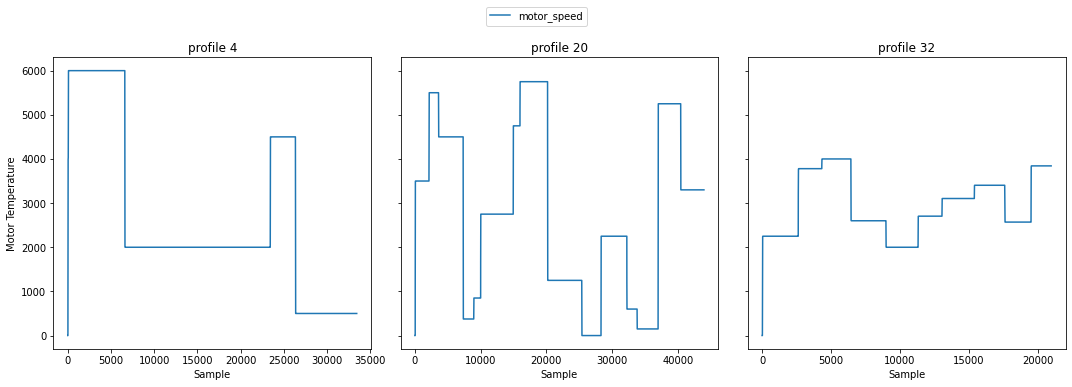

In [ ]:
stepwise_speed_profiles = [4,6,20,27,29,30,31,32,36,41,42,44,45]
stepwise_speed_profile_examples = [4,20,32]
target_features = ['motor_speed']
n_columns = 3
y_label = 'Motor Temperature in °C'

plot_profiles(stepwise_speed_profile_examples,target_features,n_columns,y_label)

**Random Speed Profiles**

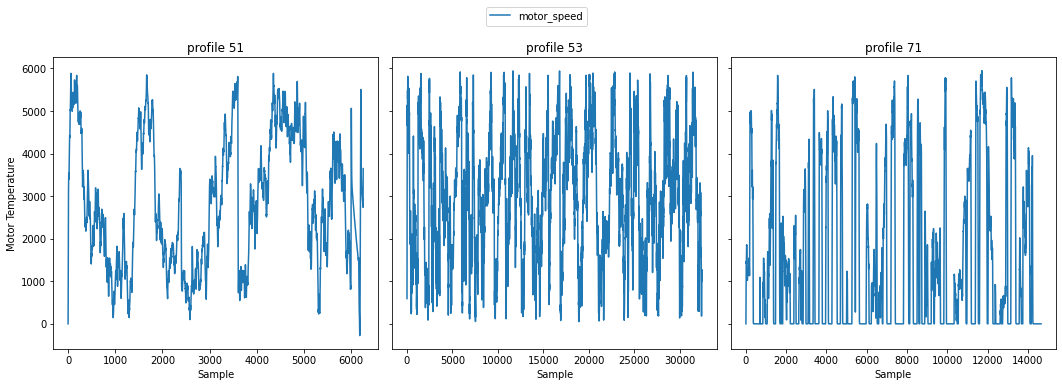

In [ ]:
random_speed_profiles = [43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81]
random_speed_profile_example = [51,53,71]

target_features = ['motor_speed']
n_columns = 3
y_label = 'Motor Temperature in °C'

plot_profiles(random_speed_profile_example,target_features,n_columns, y_label)


**PART II: WHICH PART OF THE e-MOTOR REACHES THE HIGHEST TEMPERATURE?**

Engine temperature is measured at stator yoke, stator tooth, stator windings and permanent magnet locations during the test sessions which are denoted as stator_yoke, stator_tooth, stator_winding and pm.

**Temperature Buld-Up in Constant Speed Profiles**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

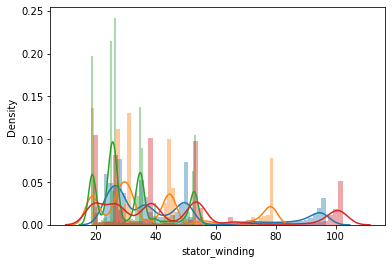

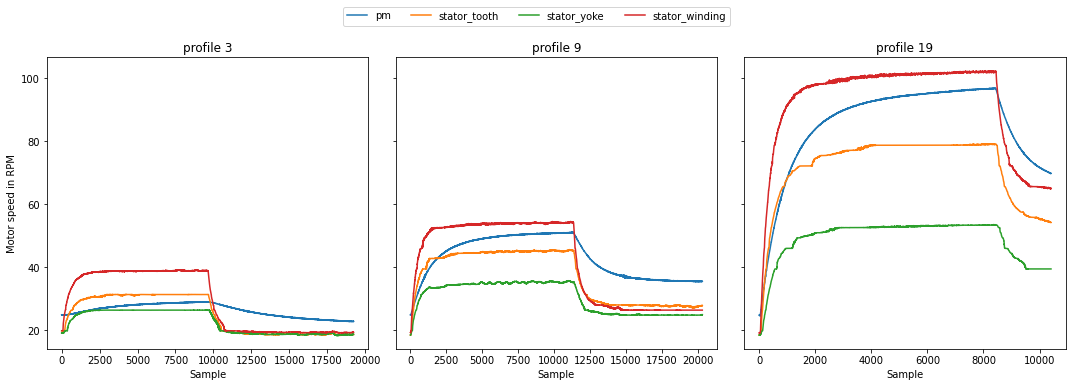

In [ ]:
constant_speed_profile_examples = [3,9,19]
target_features = ['pm','stator_tooth','stator_yoke','stator_winding']
n_columns = 3
y_label = 'Motor speed in RPM'

plot_profiles(constant_speed_profile_examples,target_features,n_columns,y_label, True)

**Temperature Buld-Up in Stepwise Speed Profiles**



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

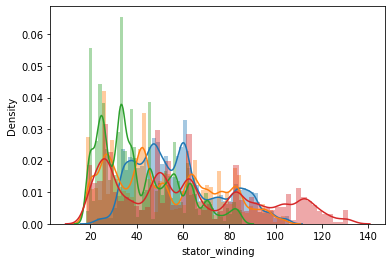

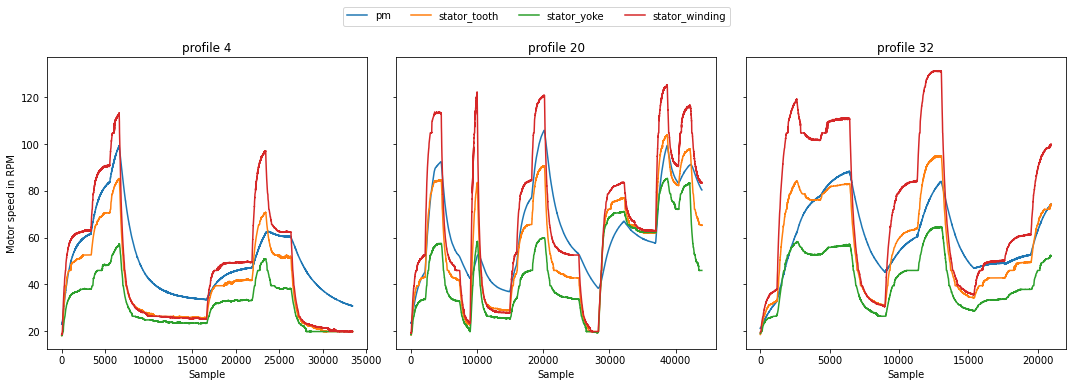

In [ ]:
stepwise_speed_profile_examples = [4,20,32]
target_features = ['pm','stator_tooth','stator_yoke','stator_winding']
n_columns = 3
y_label = 'Motor speed in RPM'

plot_profiles(stepwise_speed_profile_examples,target_features,n_columns,y_label, True)

**Temperature Buld-Up in Random Speed Profiles**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

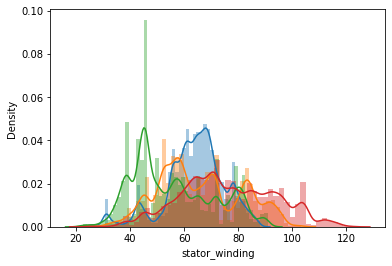

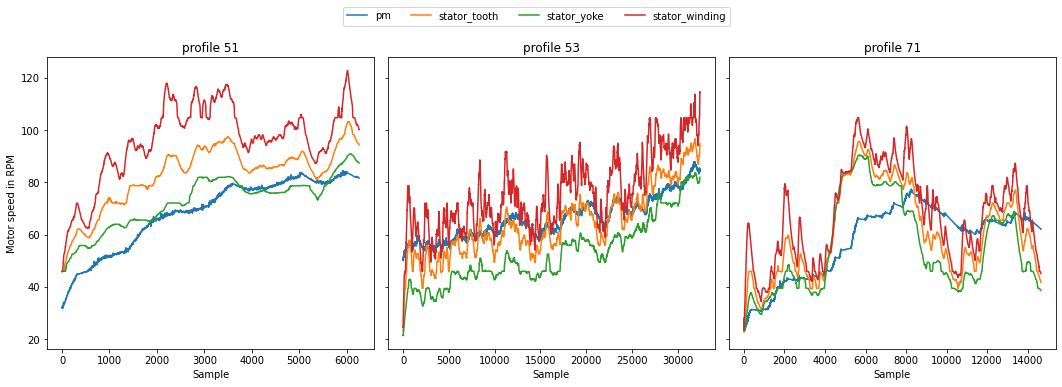

In [ ]:
random_speed_profile_examples = [51,53,71]
target_features = ['pm','stator_tooth','stator_yoke','stator_winding']
n_columns = 3
y_label = 'Motor speed in RPM'

plot_profiles(random_speed_profile_examples,target_features,n_columns,y_label, True)

The followings are the observations derived from the above graphs:

*   Stator winding reaches the highest temperature which is around 140 °C.
*   The temperature has a high positive correlation with the engine speed.
*   Permanent magnets cool down the slowest and engine windings cool down the fastest when the engine excitation stopped.
*   Profiles with random speed variation show a normal distribution of temperature while the other profiles have many local peaks separately.

**PART III: WHAT FACTORS CORRELATE WELL TO THE TEMPERATURE BUILD-UP IN AN e-MOTOR?**

**Correlation in Constant Speed Profiles**

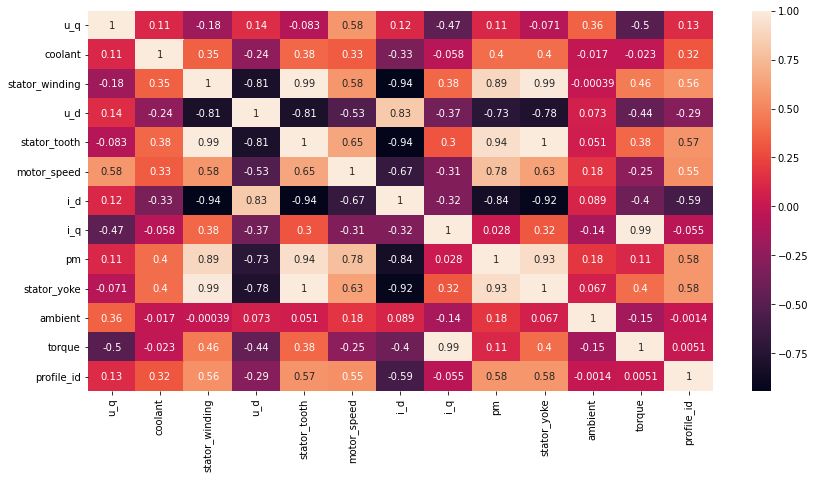

In [ ]:
constant_speed_profiles = [3,5,7,8,9,12,13,14,15,16,17,18,19,21,23,24,26]
plot_profiles(constant_speed_profiles,target_features,n_columns,y_label, False,True,False)

**Correlation in Stepwise Speed Profiles**

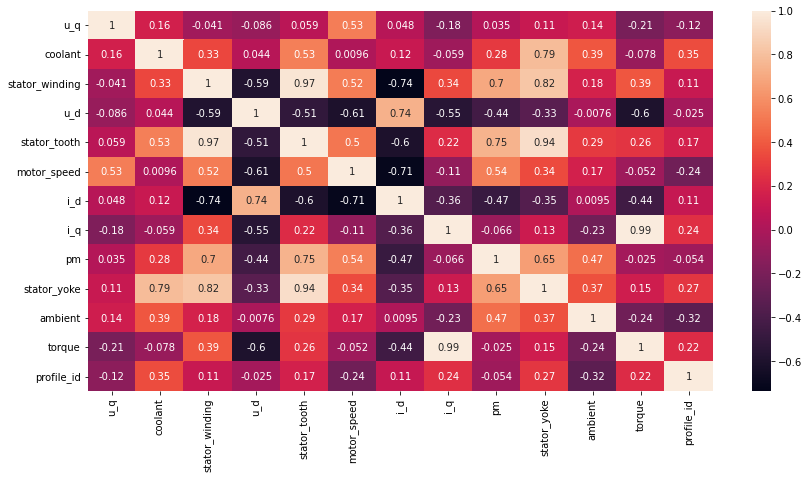

In [ ]:
stepwise_speed_profiles = [4,6,20,27,29,30,31,32,36,41,42,44,45]
plot_profiles(stepwise_speed_profiles,target_features,n_columns,y_label, False,True,False)

**Correlation in Random Speed Profiles**

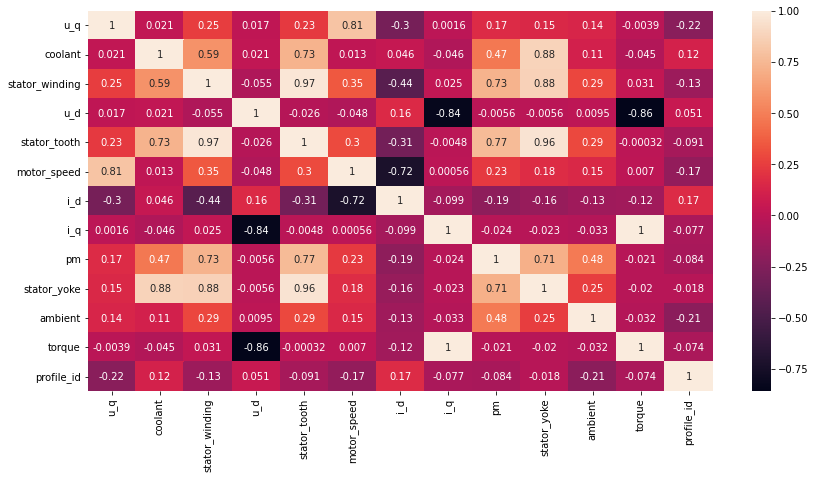

In [ ]:
random_speed_profiles = [43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81]
plot_profiles(random_speed_profiles,target_features,n_columns,y_label, False,True,False)

Engine speed and torque (denoted as motor_speed and torque) are the results of driving conditions. e-Motor controller drives the motor by adjusting the voltage level supplied to the e-Motor (denoted as u_q, u_d, i_q, i_d) to keep the vehicle in the desired speed level.

With the help of correlation matrices, we can see that stator temperature is positively correlated with engine speed. We can also clearly see that engine speed is highly correlated with voltage and current which actually make sense as it is controlled by voltage and current.

This correlation deteriorated in the profiles with random ramp-ups and slow-downs in engine speed. It can be seen that engine coolant and ambient temperature have a higher correlation with temperature in such driving modes compared to constant speed conditions.

**PART IV: HOW WELL WE CAN PREDICT TEMPERATURE OF CRITICAL COMPONENTS?**

You can see below the graph of predicted temperatures for stator windings as well as the corresponding actual measurements plotted on top for the specific profiles.

In [ ]:
dataset = pd.read_csv('/drive/MyDrive/measures_v2.csv')

# Seperating input and output variables
X = dataset.drop(['torque', 'stator_winding', 'profile_id', 'pm', 'stator_yoke', 'stator_tooth'], axis=1).values 
y = dataset['stator_winding'].values 

# split up in training and test data
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.3)

# training the Random Forest Regressor on the dataset
RFR_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
RFR_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [ ]:
# Calculate MSE and MAE for the entire testset
y_pred = RFR_model.predict(X_test)
RFR_MSE = mean_squared_error(y_test, y_pred)
RFR_MAE = mean_absolute_error(y_test, y_pred)
print("MSE: {0}".format(RFR_MSE))
print("MAE: {0}".format(RFR_MAE))

MSE: 11.046984542136602
MAE: 1.21577835903594


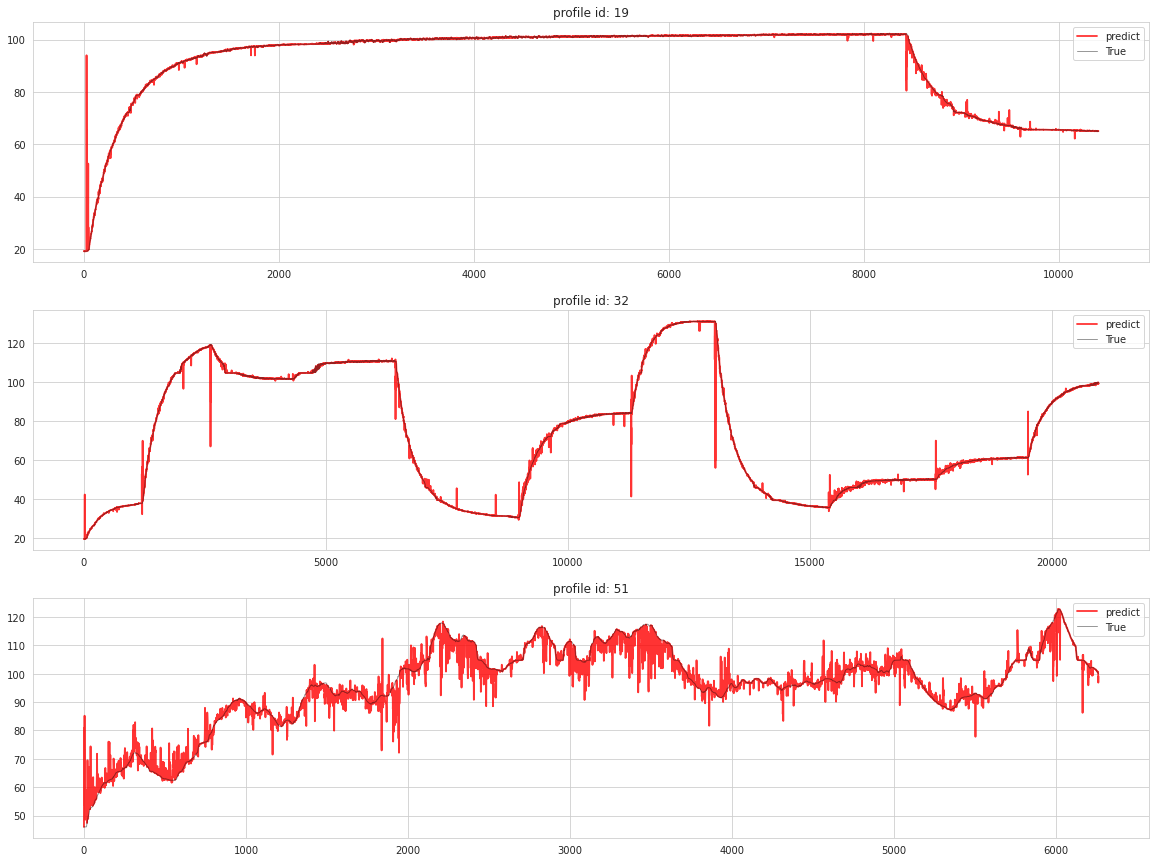

In [ ]:
# plot the true vs predicted values for multiple testruns
test_run_list = np.array([19,32,51])
#test_run_list = np.random.choice(profile_id_list, size=4, replace=False)]
output_value = 'stator_winding'
model = RFR_model

with sns.axes_style("whitegrid"):    
    fig, axs = plt.subplots(len(test_run_list),1,figsize=(20,len(test_run_list)*5),squeeze=False)
    
    for i in range(0,len(test_run_list)):
        X_plot = dataset.drop(['torque', 'stator_winding', 'profile_id', 'pm', 'stator_yoke', 'stator_tooth'], axis=1).loc[dataset['profile_id'] == test_run_list[i]].values 
        y_plot = dataset.loc[dataset['profile_id'] == test_run_list[i],output_value].values 
        y_pred_plot = model.predict(X_plot)
        y_resid = y_pred_plot - y_plot

        time = np.linspace(0, y_plot.shape[0],num=y_plot.shape[0])
        axs[i,0].plot(time,y_pred_plot,label='predict',color='red',alpha=0.8,linewidth=1.8)
        axs[i,0].plot(time,y_plot,label='True',color='black',alpha=0.4, linewidth=1)
        axs[i,0].legend(loc='best')
        axs[i,0].set_title("profile id: {0}".format(test_run_list[i]))
    plt.show() 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


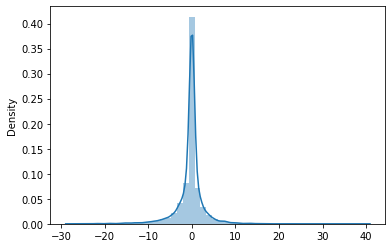

In [ ]:
df_residuals = pd.DataFrame(y_resid, columns = ['resid'])
sns.distplot(df_residuals)

The observations are:

*   In general, our model can predict the stator temperatures with an average absolute error of 1.2 C
*   %50 of the predictions is spot on with 0.7–0.2 C error
*   Profiles with random speed variations have prediction errors bigger than the constant and stepwise speed profiles.
*   Predictions are worsened when the motor speed has drastic changes
*   In extreme cases, there are 30–35 C prediction errors

**KEY TAKEAWAYS AND CONCLUSION**

*   3 different driving  profiles have been observed in data with constant, stepwise, and random speed variations.
*   Stator winding reaches the highest temperature which is around 140 °C.
*   In general, our model can predict the stator temperatures with an average absolute error of 1.2 °C, and %50 of the predictions is spot on with 0.7–0.2 °C error.


I used 180 hours of data collected from a permanent magnet synchronous motor (PMSM) by the LEA department at Paderborn University. 
Please follow the link for the [original data and corresponding ](https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature)license as well as the related [publication](https://ieeexplore.ieee.org/abstract/document/9296842).


I hope you have found the article useful.